In [1]:
! load_ext autoreload
! autoreload 2
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import torch
import os
import math
import re
from itertools import groupby
from typing import Callable, Dict, List, Optional, Set, Tuple, Type, Union

import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('../')
from lora_diffusion import LoraInjectedConv2d, LoraInjectedLinear, patch_pipe, tune_lora_scale, parse_safeloras
from lora_diffusion.lora import _find_modules, UNET_CROSSATTN_TARGET_REPLACE, DEFAULT_TARGET_REPLACE
from reg_lora.visual import visualize_images
import safetensors
import time

os.environ["DISABLE_TELEMETRY"] = 'YES'
os.environ["HTTP_PROXY"] = "http://localhost:8890"
os.environ["HTTPS_PROXY"] = "http://localhost:8890"
model_id = "runwayml/stable-diffusion-v1-5"
device = torch.device("cuda:6")
time.sleep(0.01)
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16,local_ckpt_files_only=True,revision='39593d5650112b4cc580433f6b0435385882d819').to(device)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
torch.manual_seed(0)


zsh:1: command not found: load_ext
zsh:1: command not found: autoreload


2023-09-06 16:12:14.080984: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Keyword arguments {'local_ckpt_files_only': True} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### 在attn_layer中插入hook函数, 可视化attn_map 

In [ ]:
# %%capture
import os
import sys
sys.path.append('/home/zhicai/poseVideo/lora-master/')
path = 'outputs/checkpoints/debug_decay_0.001/lora_weight_e31_s5000.safetensors'
path = 'outputs/checkpoints/output_dog_Ti-clip_Nonorm_3e-5/lora_weight_e62_s10000.safetensors'
prompt = "'a <krk1> dog in grand canyon'"

command = f"python ../reg_lora/vis_attn_map.py --lora_path {path} --prompt {prompt} --gpu 0 --name up_blocks.2.attentions.1.transformer_blocks.0.attn2"
print(command)
os.system(command)

## 计算TI之后的caption(ti-tuned)-caption的clip score

In [ ]:
all_c2c_sim_list = []
all_c2i_sim_list = []

## 计算TI后cpation-image的Clip score

In [ ]:
import re
import os
import copy
import torch

from PIL import Image
from transformers import CLIPProcessor, CLIPModel

lora_dir = '../outputs/checkpoints/dog/ti_reg/base'
root_img_path = '../dataset/data/dog'
ckpt_pattern = r'lora_weight_e\d+_s\d{3,4}.safetensors'
captions = ["photo of a <krk1> dog", "photo of a dog"]
device = 'cuda:5'
weight_dtype = torch.float32


model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device,dtype = weight_dtype)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

images = [Image.open(os.path.join(root_img_path, img_path)) for img_path in os.listdir(root_img_path)]
    
_ckpt_files = os.listdir(lora_dir)
ckpt_files = [f for f in _ckpt_files if re.match(ckpt_pattern, f)]

c2i_sim_list = []
c2c_sim_list = []
for _file in sorted(ckpt_files,
                    key = lambda x: int(re.match(r'.*e([0-9]+).*', x.split('/')[-1])[1]), 
                    reverse=False):
    
    lora_path = os.path.join(lora_dir, _file)
    print(f"loading from: {lora_path}")
    patch_pipe( 
        pipe,
        lora_path,
        patch_text=False,
        patch_ti=True,
        patch_unet=True,
        filter_crossattn_str = 'cross+self'
    )

    processor.tokenizer = pipe.tokenizer
    model.text_model = copy.deepcopy(pipe.text_encoder.text_model.to(device, dtype=weight_dtype))
    # token_embedding = model.text_model.embeddings.token_embedding
    # token_embedding.weight.data[49408] = token_embedding.weight.data[42170]    
    inputs = processor(text=captions, images=images, return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    
    image_embeds = outputs.image_embeds
    input_ids = inputs.input_ids
    last_hidden_state = outputs.text_model_output.last_hidden_state
    text_embeds = last_hidden_state[torch.arange(last_hidden_state.size(0), device=input_ids.device),
                                    [(row == 49407).nonzero().min() for row in input_ids]]
    text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
    logit_scale = model.logit_scale.exp()
    logits_per_text = torch.matmul(text_embeds, image_embeds.t()) * logit_scale
    logits_per_image = logits_per_text.t()
    c2c_sim = torch.matmul(text_embeds[0],text_embeds[1].t())
    c2c_sim_list.append(c2c_sim.item())
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
    c2i_sim_list.append(probs[:,0].mean().item())
    
all_c2c_sim_list.append(c2c_sim_list)
all_c2i_sim_list.append(c2i_sim_list)

In [ ]:
import matplotlib.pyplot as plt 
similarity = np.array_split(np.array(c2i_sim_list),2)[0]
plt.plot(np.arange(len(similarity)) * 20, similarity)
plt.show()

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(np.arange(len(c2i_sim_list)) * 200, c2i_sim_list)
plt.show()

In [ ]:
from transformers.models.clip import CLIPTextModel

lora_path = '../outputs/checkpoints/cat_decay+clip_maskId/lora_weight_e9_s1000.safetensors'
patch_pipe( 
        pipe,
        lora_path,
        patch_text=False,
        patch_ti=True,
        patch_unet=True,
        filter_crossattn_str = 'cross+self'
)

prompt = ["a photo of a dog swimming in a pool","a photo of a <krk1> dog swimming in a pool"]
text_inputs = pipe.tokenizer(
                prompt,
                padding="max_length",
                max_length=pipe.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
device = pipe.text_encoder.device
text_input_ids = text_inputs.input_ids.to(device)
global_eot_ids = [(row == 49407).nonzero().min() for row in text_input_ids]
bs = len(prompt)
outputs = pipe.text_encoder(
                text_input_ids.to(device),
                attention_mask=None,
                output_attentions = True,
            )
attentions = []


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# data = sns.load_dataset("flights")
# data = data.pivot("month", "year", "passengers")
for attention in outputs.attentions:
    attentions.append(attention.mean(dim=1)[torch.arange(bs,device = device), 7, :12].detach().cpu().numpy())
attentions = np.stack(attentions, axis=1)
print(attentions[1].round(3))
idx = 1
xticklabels = ['<sot>'] + prompt[idx].split(' ') + ['<eot>']
yticklabels = np.arange(12) + 1
sns.set(font_scale=0.7)
ax = sns.heatmap(attentions[idx].round(2), annot=True,xticklabels=xticklabels,yticklabels=yticklabels, linewidths=.5, cmap="YlGnBu")
ax.set_xlabel("prompt")
ax.set_ylabel("layer")
plt.show()


### 统计Lora中的self和cross attn模块中的Linear-layer权重漂移和对文本映射后的语义漂移

In [ ]:
target_dir = '../output_dog'
test_prompts = ['a dog','a cat','a teddybear','a chair']
reg_prompt = ['photo of a dog']

lora_weight_norm_list_cross = []
lora_weight_norm_list_self = []
lora_context_reg_resides_list = []

# 找到cross_attn 和 self_attn的位置
cnt = 0
cross_idxs = []
self_idxs = []
for target, name, module in _find_modules(pipe.unet, DEFAULT_TARGET_REPLACE):
    if module.in_features == 768:
        cross_idxs.append(cnt)
    if module.in_features != 320 and (name == 'to_k' or name == 'to_v'):
        self_idxs.append(cnt)
    cnt += 1 

c_reg = pipe._encode_prompt(reg_prompt,device,1,False)
group = [ckpt_file  for ckpt_file in os.listdir(target_dir) if '_s' in ckpt_file and 'lora_weight' in ckpt_file]
print(group)
sorted_group = sorted(group, key = lambda x: int(re.findall(r'.*s(\d+).*',x)[0]))

for ckpt_file in sorted_group:
        cur_step_list_cross = []
        cur_step_context_reg_reside = []
        cur_step_list_self = []
        ckpt = safetensors.safe_open(os.path.join(target_dir,ckpt_file), framework="pt", device="cpu")
        lora = parse_safeloras(ckpt)  
        for cross_idx , self_idx in zip(cross_idxs,self_idxs):
                up_weight_self = lora['unet'][0][2*self_idx].to(device)
                down_weight_self = lora['unet'][0][2*self_idx+1].to(device)
                up_weight = lora['unet'][0][2*cross_idx].to(device)
                down_weight = lora['unet'][0][2*cross_idx+1].to(device)
                cur_step_lora_project_self = down_weight_self.transpose(0,1) @ up_weight_self.transpose(0,1)
                cur_step_lora_project_cross = down_weight.transpose(0,1) @ up_weight.transpose(0,1)
                cur_step_lora_reside = c_reg @ cur_step_lora_project_cross
                cur_step_context_reg_reside.append(torch.norm(cur_step_lora_reside).cpu().item())
                cur_step_list_cross.append(torch.norm(cur_step_lora_project_cross).cpu().item()) 
                cur_step_list_self.append(torch.norm(cur_step_lora_project_self).cpu().item())
        lora_weight_norm_list_cross.append(np.mean(cur_step_list_cross))
        lora_context_reg_resides_list.append(np.mean(cur_step_context_reg_reside))
        lora_weight_norm_list_self.append(np.mean(cur_step_list_self))

print(lora_weight_norm_list_cross[4:],'\n',lora_weight_norm_list_self[4:],'\n',lora_context_reg_resides_list[4:])

In [ ]:

def get_identifier_masked_causal_attention_mask(bs, seq_len, identifier_indices, class_token_len: int = -1, dtype = torch.float16):
    print(len(identifier_indices[0]))
    if identifier_indices is not None and len(identifier_indices[0]): 
        assert class_token_len >= 1
        for i, identifier_indice in zip(identifier_indices[0],identifier_indices[1]):
            print(i)
            mask = torch.empty(bs, seq_len, seq_len, dtype=dtype)
            mask.fill_(torch.tensor(torch.finfo(dtype).min))
            mask.triu_(1)  # zero out the lower diagonal
            mask = mask.unsqueeze(1)  # expand mask
            mask[i,:,identifier_indice, 1:max(identifier_indice,1)] = torch.finfo(dtype).min
            mask[i,:,identifier_indice+class_token_len+1:,identifier_indice] = torch.finfo(dtype).min
    else:
        mask = torch.empty(bs, seq_len, seq_len, dtype=dtype)
        mask.fill_(torch.tensor(torch.finfo(dtype).min))
        mask.triu_(1)  # zero out the lower diagonal
        mask = mask.unsqueeze(1)  # expand mask

    return mask

mask = get_identifier_masked_causal_attention_mask(1,77,[[0],[3]],1)


In [ ]:
mask[0,0,5]

## Visualization figures

In [2]:
def identity_scale_ratio(*args, **kwargs):
    pass

def linear_scale_ratio(i, t, latents, self, num_inference_steps=50):
    scale = np.linspace(0, 1, num_inference_steps)[i]
    print(f"Linear scale ratio: {scale}")
    tune_lora_scale(self.unet, scale)

<krk1>


  0%|          | 0/50 [00:00<?, ?it/s]

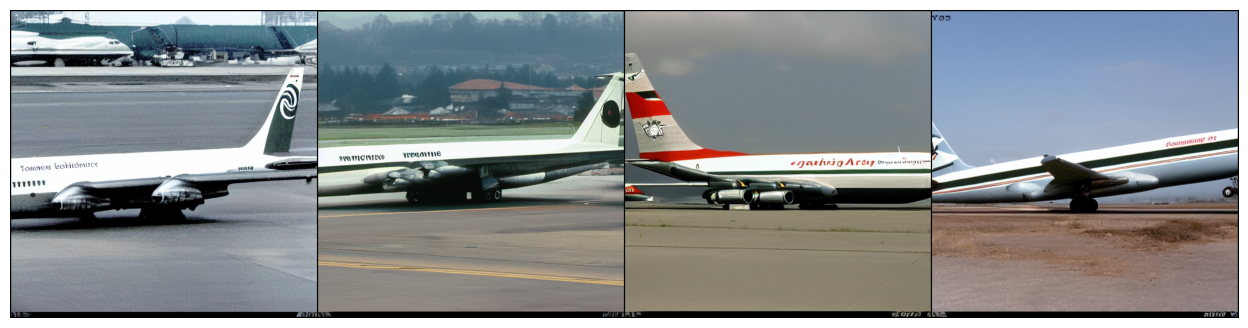

In [3]:
import copy
from functools import partial
import sys

lora_ckpts = [
              '/data/zhicai/code/Text-regularized-customization/outputs/checkpoints/aircraft/ewc_reg/baseline_lora_rank_10/lora_weight_s1400.safetensors'
              ]

prompts = ['photo of a <krk1> aircraft']
bs = 4
num_inference_steps = 50
weight_dtype = torch.float16
use_scale = False
pipe_copy = copy.deepcopy(pipe).to(device)
torch.manual_seed(0)
latents = torch.randn((bs,4,64,64), device=device, dtype=weight_dtype)
# pipe_copy.text_encoder = my_text_encoder
img_list = []
for lora_ckpt in lora_ckpts:
    patch_pipe(
        pipe_copy,
        lora_ckpt,
        patch_text=False,
        patch_ti=True,
        patch_unet=True,
        filter_crossattn_str = 'cross+self'
    )
    # pipe.unet
    tune_lora_scale(pipe_copy.unet, 1)
    partial_linear_scale_ratio = partial(linear_scale_ratio, self=pipe_copy, num_inference_steps=num_inference_steps) if use_scale else identity_scale_ratio
    pipe_copy.text_encoder.text_model.to(device, dtype=weight_dtype)
    # tune_lora_scale(pipe_copy.text_encoder, 1)
    for prompt in prompts:
        prompt = [prompt]*bs
        img = pipe_copy(prompt = prompt, 
                        num_inference_steps=num_inference_steps,
                        guidance_scale=6,
                        latents = latents,
                        callback=partial_linear_scale_ratio,
                        callback_steps=1).images
        img_list.extend(img)
img = visualize_images(img_list,outpath='ewc_shareTI_weight-1.pdf', nrow=bs*len(prompts), show=True,save=False)

In [ ]:
visualize_images(img_list,outpath='baseline.pdf', nrow=bs*len(prompts), show=False,save=True)

In [ ]:
import copy
from functools import partial
import sys

lora_ckpts = [
                '../outputs/checkpoints/dog/ewc_reg_shareTI/ewc_real_weight_0.01_rank_10/lora_weight_s3000.safetensors'
              ]

prompts = ['photo of a <krk1> dog in grand canyon', 'photo of a <krk1> dog swimming in a pool', 'photo of a dog', 'photo of a dog swimming in a pool']
bs = 4
num_inference_steps = 50
weight_dtype = torch.float16
use_scale = False
pipe_copy = copy.deepcopy(pipe).to(device)
torch.manual_seed(0)
# pipe_copy.text_encoder = my_text_encoder
img_list = []
for lora_ckpt in lora_ckpts:
    patch_pipe(
        pipe_copy,
        lora_ckpt,
        patch_text=False,
        patch_ti=True,
        patch_unet=True,
        filter_crossattn_str = 'cross+self'
    )
    # pipe.unet
    tune_lora_scale(pipe_copy.unet, 1)
    partial_linear_scale_ratio = partial(linear_scale_ratio, self=pipe_copy, num_inference_steps=num_inference_steps) if use_scale else identity_scale_ratio
    pipe_copy.text_encoder.text_model.to(device, dtype=weight_dtype)
    # tune_lora_scale(pipe_copy.text_encoder, 1)
    for prompt in prompts:
        prompt = [prompt]*bs
        img = pipe_copy(prompt = prompt, 
                        num_inference_steps=num_inference_steps,
                        guidance_scale=6,
                        callback=partial_linear_scale_ratio,
                        callback_steps=1).images
        img_list.extend(img)
img = visualize_images(img_list,outpath='real_gen_ewc.pdf', nrow=bs*len(prompts), show=True,save=False)

In [ ]:
import copy
lora_ckpts = ['../outputs/checkpoints/debug_decay_mask_0.001/lora_weight_e31_s5000.safetensors']
prompts = ['photo of a <krk1> dog and a cat', 'photo of a cat and a <krk1> dog']
bs = 4
weight_dtype = torch.float16
device = "cuda:2"
pipe_copy = copy.deepcopy(pipe).to(device)
torch.manual_seed(0)
patch_pipe(
    pipe_copy,
    lora_ckpts[0],
    patch_text=False,
    patch_ti=True,
    patch_unet=True,
    filter_crossattn_str = 'cross+self'
)
# pipe.unet
tune_lora_scale(pipe_copy.unet, 0)
pipe_copy.text_encoder.text_model.to(device, dtype=weight_dtype)
# tune_lora_scale(pipe_copy.text_encoder, 1)
for prompt in prompts:
    prompt = [prompt]*bs
    img = pipe_copy(prompt = prompt, num_inference_steps=50, guidance_scale=6).images
    visualize_images(img,outpath='figure/', nrow=4, show=True,save=False)

In [ ]:
import copy
lora_ckpts = ['../outputs/checkpoints/NT-clipDecay-mask']
prompts = ['photo of a <krk1> dog', 'photo of a <krk1> dog swimming in a pool', 'photo of a <krk1> dog in grand canyon']
bs = 4
weight_dtype = torch.float16
device = "cuda:2"
pipe_copy = copy.deepcopy(pipe).to(device)
torch.manual_seed(0)
patch_pipe(
    pipe_copy,
    lora_ckpts[0],
    patch_text=False,
    patch_ti=True,
    patch_unet=True,
    filter_crossattn_str = 'cross+self'
)
# pipe.unet
tune_lora_scale(pipe_copy.unet, 1)
pipe_copy.text_encoder.text_model.to(device, dtype=weight_dtype)
# tune_lora_scale(pipe_copy.text_encoder, 1)
for prompt in prompts:
    prompt = [prompt]*bs
    img = pipe_copy(prompt = prompt, num_inference_steps=50, guidance_scale=6).images
    visualize_images(img,outpath='figure/', nrow=4, show=True,save=False)

In [ ]:
import copy
lora_ckpts = ['../outputs/checkpoints/NT-Decay/lora_weight_e12_s2000.safetensors']
prompts = ['photo of a <krk1> dog', 'photo of a <krk1> dog swimming in a pool']
bs = 4
weight_dtype = torch.float16
device = "cuda:2"
pipe_copy = copy.deepcopy(pipe).to(device)
torch.manual_seed(0)
patch_pipe(
    pipe_copy,
    lora_ckpts[0],
    patch_text=False,
    patch_ti=True,
    patch_unet=True,
    filter_crossattn_str = 'cross+self'
)
# pipe.unet
tune_lora_scale(pipe_copy.unet, 1)
pipe_copy.text_encoder.text_model.to(device, dtype=weight_dtype)
# tune_lora_scale(pipe_copy.text_encoder, 1)
for prompt in prompts:
    prompt = [prompt]*bs
    img = pipe_copy(prompt = prompt, num_inference_steps=50, guidance_scale=6).images
    visualize_images(img,outpath='figure/', nrow=4, show=True,save=False)

## Masked attention projection

In [ ]:
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput

# print(input_ids)
def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, tgt_len: Optional[int] = None):
    """
    Expands attention_mask from `[bsz, seq_len]` to `[bsz, 1, tgt_seq_len, src_seq_len]`.
    """
    bsz, src_len = mask.size()
    tgt_len = tgt_len if tgt_len is not None else src_len

    expanded_mask = mask[:, None, None, :].expand(bsz, 1, tgt_len, src_len).to(dtype)

    inverted_mask = 1.0 - expanded_mask
    return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(dtype).min)

def get_identifier_masked_causal_attention_mask(bs, seq_len, identifier_indice, class_token_len, dtype = torch.float16):
    mask = torch.empty(bs, seq_len, seq_len, dtype=dtype)
    mask.fill_(torch.tensor(torch.finfo(dtype).min))
    mask.triu_(1)  # zero out the lower diagonal
    mask = mask.unsqueeze(1)  # expand mask
    mask[:,:,identifier_indice, 1:max(identifier_indice,1)] = torch.finfo(dtype).min
    mask[:,:,identifier_indice+class_token_len+1:,identifier_indice] = torch.finfo(dtype).min
    return mask

def build_causal_attention_mask( bs, seq_len, dtype):
    mask = torch.empty(bs, seq_len, seq_len, dtype=dtype)
    mask.fill_(torch.tensor(torch.finfo(dtype).min))
    mask.triu_(1)  # zero out the lower diagonal
    mask = mask.unsqueeze(1)  # expand mask
    return mask

@torch.no_grad()
def generate_with_hidden_input(pipe, hidden_states ,num_images_per_prompt=1, num_inference_steps=50, guidance_scale=6):

    text_embeddings = hidden_states
    batch_size = hidden_states.size(0)
    do_classifier_free_guidance = guidance_scale > 1.0
    if do_classifier_free_guidance:
        uncond_tokens = [""] * batch_size
        uncond_input = pipe.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=pipe.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
        uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device), attention_mask = None)[0]
        bs_embed, seq_len, _ = text_embeddings.shape
        text_embeddings = text_embeddings.repeat(1, num_images_per_prompt, 1)
        text_embeddings = text_embeddings.view(bs_embed * num_images_per_prompt, seq_len, -1)
        uncond_embeddings = uncond_embeddings.repeat(1, num_images_per_prompt, 1)
        uncond_embeddings = uncond_embeddings.view(batch_size * num_images_per_prompt, seq_len, -1)
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    height =  pipe.unet.config.sample_size * pipe.vae_scale_factor
    width = pipe.unet.config.sample_size * pipe.vae_scale_factor
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = pipe.scheduler.timesteps

    # 5. Prepare latent variables
    num_channels_latents = pipe.unet.in_channels
    latents = pipe.prepare_latents(
        batch_size * num_images_per_prompt,
        num_channels_latents,
        height,
        width,
        text_embeddings.dtype,
        device,
        None,
        None,
    )

    # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
    extra_step_kwargs = pipe.prepare_extra_step_kwargs(None, 0.0)

    # 7. Denoising loop
    num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order
    with pipe.progress_bar(total=num_inference_steps) as progress_bar:
        for i, t in enumerate(timesteps):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = pipe.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

            # call the callback, if provided
            if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0):
                progress_bar.update()

    # 8. Post-processing
    image = pipe.decode_latents(latents)

    # 9. Run safety checker
    # image, has_nsfw_concept = pipe.run_safety_checker(image, device, text_embeddings.dtype)
    # 10. Convert to PIL
    image = pipe.numpy_to_pil(image)

    return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=None)


inputs = pipe.tokenizer(["photo of a red dog in grand canyon"], return_tensors="pt", max_length=77, truncation=True, padding='max_length')
input_ids = inputs.input_ids.to(device)
identifier_masked_causal_attention_mask = get_identifier_masked_causal_attention_mask(1, 77 ,4, 1, dtype= torch.float16).to(device)
causal_attention_mask = build_causal_attention_mask(1, 77, dtype= torch.float16).to(device)
clip_text_model = pipe.text_encoder.text_model
hidden_states = clip_text_model.embeddings(input_ids=input_ids)
outputs = clip_text_model.encoder(hidden_states,
                    causal_attention_mask = identifier_masked_causal_attention_mask,
                    # attention_mask = _expand_mask(attention_mask, torch.float16, 77).to(device),
                    output_attentions=True)
text_embedings = clip_text_model.final_layer_norm(outputs[0])
print(text_embedings.size())
imgs = generate_with_hidden_input(pipe, text_embedings, num_images_per_prompt = 4 , num_inference_steps=50, guidance_scale=6).images


In [ ]:
visualize_images(imgs,save=False,nrow=4,show=True)

## Fisher

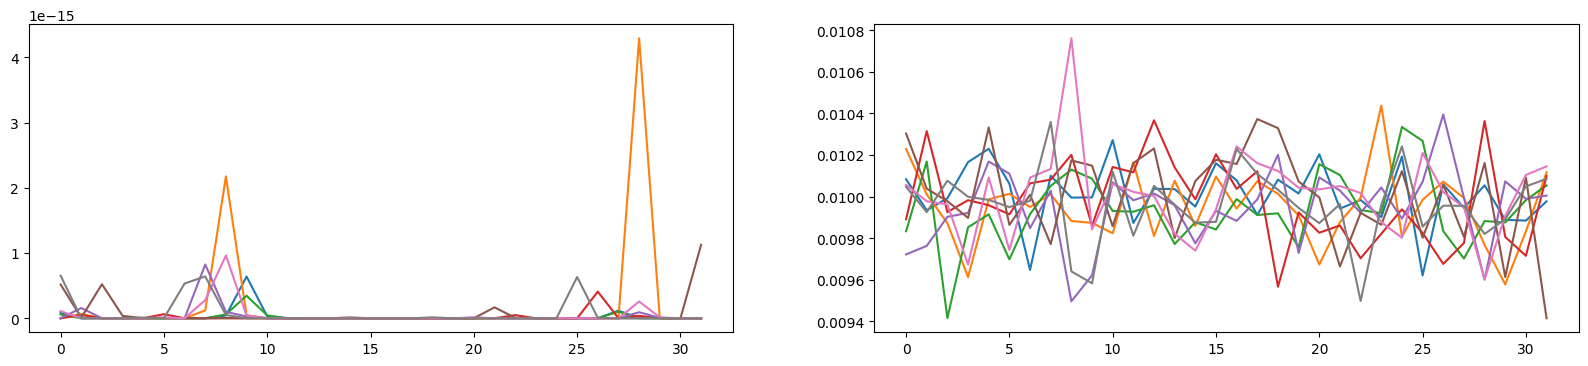

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob

path_list = glob.glob('/data/zhicai/code/Text-regularized-customization/outputs/checkpoints/wooden_pot/ewc_reg_shareTI/ewc_gen_weight_0.01_rank_10_seed_*/fisher.pt')
path_list.extend(glob.glob('/data/zhicai/code/Text-regularized-customization/outputs/checkpoints/wooden_pot/ewc_reg_shareTI/ewc_real_weight_0.01_rank_10_seed_*/fisher.pt'))
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
for path in path_list:
    ewc_statics = torch.load(path)
    fishers = ewc_statics['fisher_list']
    lora_ups = ewc_statics['lora_up_list']
    lora_downs = ewc_statics['lora_down_list']
    fisher_mean = [fisher.pow(2).cpu().numpy().mean() for fisher in fishers]
    lora_down_mean = [lora_down.pow(2).cpu().numpy().mean() for lora_down in lora_downs]
    axes[0].plot(fisher_mean)
    axes[1].plot(lora_down_mean)
plt.show()

<krk1>
The tokenizer already contains the token <krk1>.
Replacing <krk1> embedding.


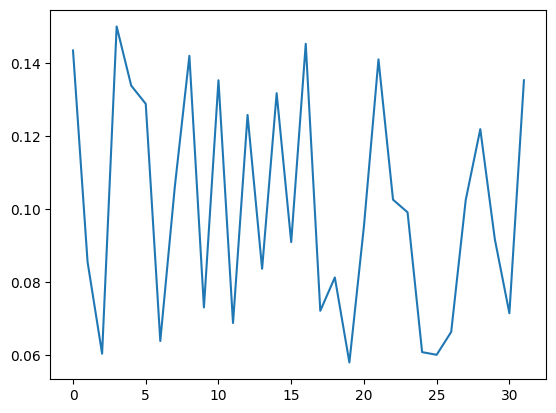

In [10]:
import sys
sys.path.append('../')
from safetensors.torch import safe_open
from lora_diffusion.lora import filter_unet_to_norm_weights
lora_ckpt = '../outputs/checkpoints/dog/ewc_reg_shareTI/freeze-down_lora_rank_10/lora_weight_s1100.safetensors'
patch_pipe(
    pipe,
    lora_ckpt,
    patch_text=False,
    patch_ti=True,
    patch_unet=True,
    filter_crossattn_str = 'cross+self'
    )
to_reg_params = filter_unet_to_norm_weights(pipe.unet, target_replace_module=UNET_CROSSATTN_TARGET_REPLACE)
lora_up_list = []
lora_down_list = []
for module in to_reg_params["other_loras"]:
    lora_up_list.append(module.lora_up.weight.data.norm().cpu())
    lora_down_list.append(module.lora_down.weight.data.mean().cpu())
plt.plot(lora_up_list, label='lora_up')
plt.show()

In [ ]:
# plt.figure(figsize=(10,10))
fig,axs = plt.subplots(8,4,figsize=(20,10))
for i in range(len(fishers)):
    fisher  = fishers[i].cpu().numpy().flatten()
    mean = fisher.mean()
    fisher=fisher/mean
    axs[i//4,i%4].hist(fisher, bins=100)
    axs[i//4,i%4].tick_params(labelsize=5)
    # plt.hist(fishers[i].cpu().numpy().flatten(), bins=100)
    # plt.show()
plt.savefig('fisher_distribution.pdf')
plt.show()

In [ ]:
for fisher in fishers:
    fisher = fisher.cpu().numpy()
    mean = fisher.mean()
    fisher=fisher/mean

In [6]:
import torch
a = torch.randn(3,3).pow(2)/100
det_a = torch.det(a)
norm_a = a.norm(2)
a_norm = a / norm_a
norm_a

tensor(0.0408)

tensor(0.0390)

In [16]:
a

tensor([[8.3696e-04, 3.6537e-03, 5.5060e-03],
        [3.3479e-05, 6.7687e-02, 3.8442e-03],
        [2.7666e-02, 2.7739e-04, 1.8532e-04]])